# 1. Подготовка

In [1]:
!pip install catboost
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from catboost import Pool, CatBoost
import lightgbm as lgb
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Чтение датасета.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/taxi.csv', parse_dates=['datetime'])

In [4]:
df.duplicated().sum()

0

##### Дубликаты отсутствуют.

###  Перевод столбца ['datetime'] в индекс

In [5]:
df = df.set_index('datetime')

### Ознакомление.

In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


# 2. Анализ

### Ресемплирование по 1 часу.

In [7]:
df = df.resample('1H').sum()

### Проверка сезонности, тренда и шума.

In [8]:
decomposed = seasonal_decompose(df)

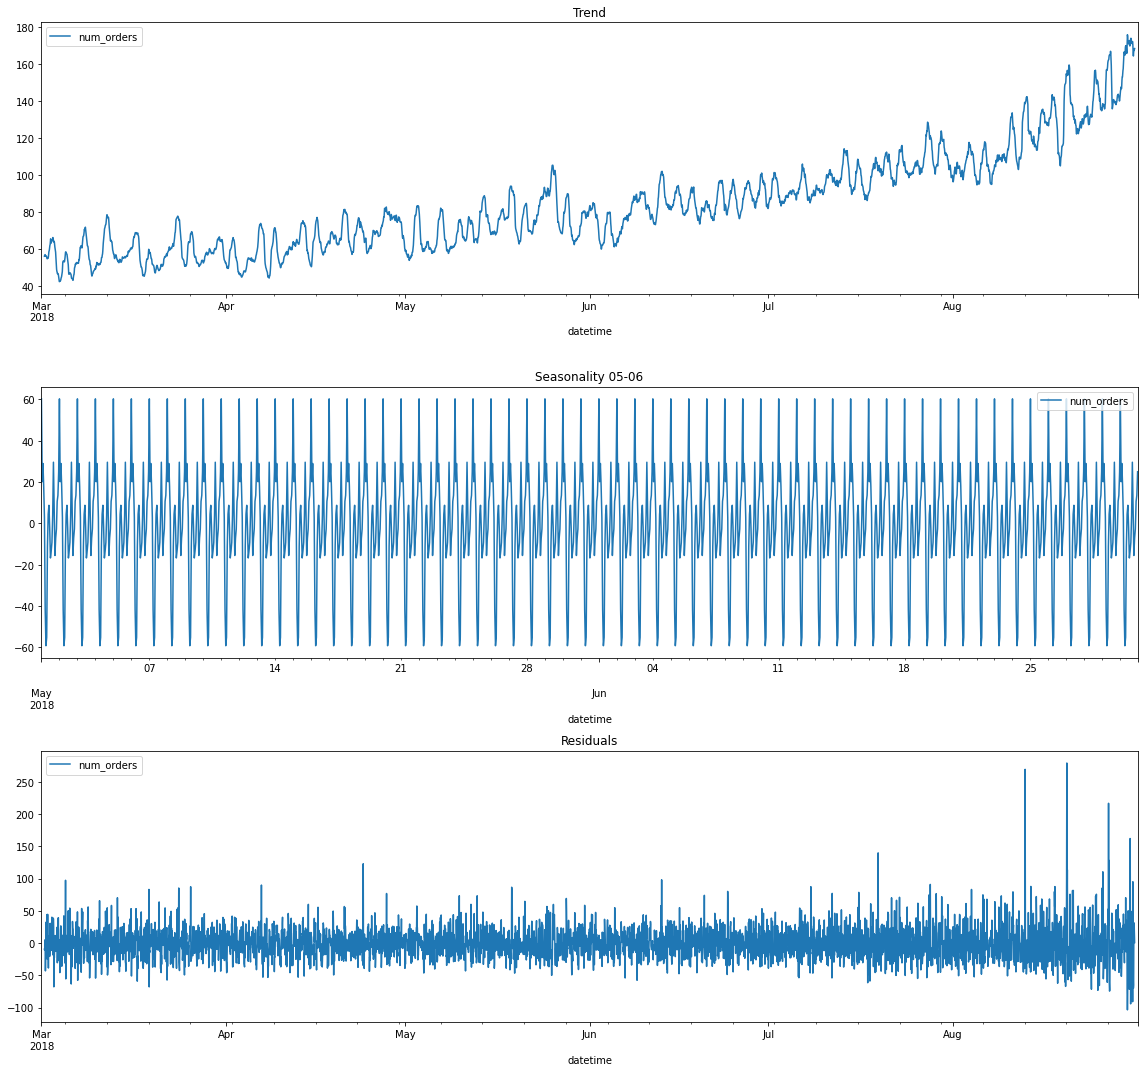

In [9]:
plt.figure(figsize=(16, 15))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
#plt.subplot(312)
#decomposed.seasonal.plot(ax=plt.gca())
#plt.title('Seasonality')
plt.subplot(312)
decomposed.seasonal['2018-05':'2018-06'].plot(ax=plt.gca())
plt.title('Seasonality 05-06')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

##### Вывод: Судя по графику сезонности - имеется короткая по промежуткам сезонность. График тренда показывает, что количество заказов растёт.

### Смотрим сезонность на отрезке двух дней.

In [10]:
df['2018-05-14':'2018-05-16']

,num_orders
datetime,
2018-05-14 00:00:00,158
2018-05-14 01:00:00,106
2018-05-14 02:00:00,164
2018-05-14 03:00:00,129
2018-05-14 04:00:00,58
...,...
2018-05-16 19:00:00,86
2018-05-16 20:00:00,63
2018-05-16 21:00:00,64


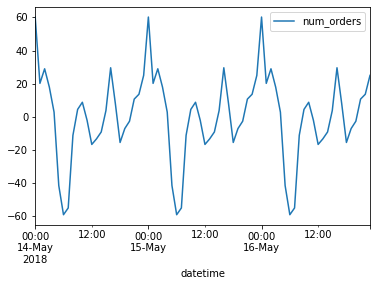

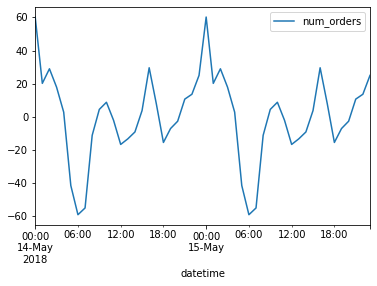

In [11]:
decomposed.seasonal['2018-05-14':'2018-05-16'].plot()
decomposed.seasonal['2018-05-14':'2018-05-15'].plot()

##### Вывод: видим четко выраженную внутридневную сезонность. Количество заказов растёт к вечеру и падает к утру.

### Проверка на монотонность.

In [12]:
df.index.is_monotonic

True

##### Индекс монотонный.

In [13]:
df.isna().sum()

num_orders    0
dtype: int64

##### Пропуски отсутствуют.

### Поиск выбросов.

In [14]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [15]:
df[df['num_orders']==0]['num_orders'].count()

1

##### Непонятно, нулевое значения это выброс или нет, возможно это нормальное количество заказов. Также необходимо сохранить данные монотонными. Насчёт 119 - тоже непонятно. Все значения решил оставить, так как продажи бывают разными.

### Добавление столбцов с годом, месяцем и днём.

In [16]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek

### Добавление скользящего среднего.

In [17]:
rolling_size = 24
df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_size).mean()

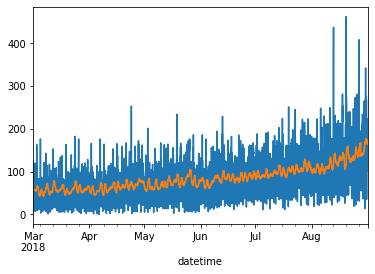

In [18]:
df['num_orders'].plot()
df['rolling_mean'].plot()

### Добавление лага.

In [19]:
max_lag = 24
for lag in range(1, max_lag + 1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

##### Удаление пропущенных значений.

In [20]:
df = df.dropna()

In [21]:
df.index.is_monotonic

True

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4392 entries, 2018-03-02 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4392 non-null   int64  
 1   hour          4392 non-null   int64  
 2   day           4392 non-null   int64  
 3   dayofweek     4392 non-null   int64  
 4   rolling_mean  4392 non-null   float64
 5   lag_1         4392 non-null   float64
 6   lag_2         4392 non-null   float64
 7   lag_3         4392 non-null   float64
 8   lag_4         4392 non-null   float64
 9   lag_5         4392 non-null   float64
 10  lag_6         4392 non-null   float64
 11  lag_7         4392 non-null   float64
 12  lag_8         4392 non-null   float64
 13  lag_9         4392 non-null   float64
 14  lag_10        4392 non-null   float64
 15  lag_11        4392 non-null   float64
 16  lag_12        4392 non-null   float64
 17  lag_13        4392 non-null

# 3. Обучение

### Масштабирование признаков.

In [23]:
cols = df.columns[1:]
scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])

### Разбивка на features и target, train и test.

In [24]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']
print(features.shape)
print(target.shape)

(4392, 28)
(4392,)


In [25]:
x_train, x_to_split, y_train, y_to_split = train_test_split(features, target, shuffle=False, test_size=0.3)
x_valid, x_test, y_valid, y_test = train_test_split(x_to_split, y_to_split, shuffle=False, test_size=0.34)

In [26]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(3074, 28)
(3074,)
(869, 28)
(869,)
(449, 28)
(449,)


### LinearLegression.

In [27]:
reg = LinearRegression().fit(x_train, y_train)
reg_predict = reg.predict(x_valid)
print('RMSE LinearRegression:', round(mean_squared_error(y_valid, reg_predict)**0.5,5))

RMSE LinearRegression: 32.85061


### XGBoost.

In [28]:
booster = ['gbtree','gblinear']
max_depth = [10,15,20,30]

In [29]:
#%%time
#acc = pd.DataFrame(columns = ['booster','max_depth','RMSE'])
#for i in booster:
#    for j in max_depth:
#        xgbr = xgb.XGBRegressor(booster=i, max_depth=j, random_state=12345, n_jobs=-1).fit(x_train, y_train)
#        answers_xgb = xgbr.predict(x_valid)
#        rmse_xgb = mean_squared_error(y_valid, answers_xgb)**0.5
#        acc = acc.append({'booster':i, 'max_depth':j,'RMSE':round(rmse_xgb,5)}, ignore_index=True)
#print(acc.sort_values('RMSE', ascending=True))

##### Лучший результат показала модель XGBoost: booster = 'gbtree', max_depth=15, RMSE=36.31693. Выборка слишком мала, поэтому результат хуже, чем у линейной регрессии.

### LightGBM.

In [30]:
num_leaves = [31,40,50]
min_child_samples=[10,20,30,40]
max_depth =[10,20,30,50,100]

In [31]:
#%%time
#acc = pd.DataFrame(columns = ['num_leaves','max_depth','min_child_samples','RMSE'])
#counter = 0
#for i in max_depth:
#    for j in min_child_samples:
#        for k in num_leaves:
#            gbm = lgb.LGBMRegressor(max_depth=i,min_child_samples=j,num_leaves=k,random_state=12345, n_jobs=-1).fit(x_train, y_train)
#            answers_gbm = gbm.predict(x_valid, num_iteration=gbm.best_iteration_)
#            rmse_gbm = mean_squared_error(y_valid, answers_gbm)**0.5
#            acc = acc.append({'num_leaves':k,'max_depth':i, 'min_child_samples':j,'RMSE':round(rmse_gbm,5)}, ignore_index=True)
#            print(counter)
#            counter += 1
#print(acc.sort_values('RMSE', ascending=True))

##### Лучший результат показала модель LightGBM: num_leaves = 31, max_depth=10, min_child_samples=10, RMSE=32.58662.

### Catboost.

In [32]:
iterations = [100,120,130]
depth = [3,7,10]

In [33]:
#%%time
#acc = pd.DataFrame(columns = ['depth','iterations','RMSE'])
#counter = 0
#for i in iterations:
#    for j in depth:
#        cbr = CatBoostRegressor(iterations=i, depth=j, random_state=12345,loss_function='RMSE', verbose=500).fit(x_train, y_train)
#        answers_cbr = cbr.predict(x_valid)
#        rmse_cbr = mean_squared_error(y_valid, answers_cbr)**0.5
#        acc = acc.append({'iterations':i, 'depth':j,'RMSE':round(rmse_cbr,5)}, ignore_index=True)
#        print(counter)
#        counter += 1
#print(acc.sort_values('RMSE', ascending=True))

##### Лучший результат показала модель Catboost: iterations = 130, depth=7, RMSE=35.01447.

### Модель регрессии случайный лес.

In [34]:
max_depth = [10,20,30,50,100,150,200]
n_estimators = [10,20,30,50,100,130,150]

In [35]:
#%%time
#acc = pd.DataFrame(columns = ['max_depth','n_estimators','RMSE'])
#counter = 0
#for i in max_depth:
#    for j in n_estimators:
#        regr = RandomForestRegressor(max_depth=i, n_estimators=j).fit(x_train, y_train)
#        answers_regr = regr.predict(x_valid)
#        rmse_regr= mean_squared_error(y_valid, answers_regr)**0.5
#        acc = acc.append({'max_depth':i, 'n_estimators':j,'RMSE':round(rmse_regr,5)}, ignore_index=True)
#        print(counter)
#        counter += 1
#print(acc.sort_values('RMSE', ascending=True))

##### Лучший результат показала модель RandomForest: max_depth = 20, n_estimators=30, RMSE=33.13836.

### Модель регрессии дерево решений.¶

In [36]:
splitter = ['best', 'random']
max_depth = [10,20,30,50,100,150,200]
samples_split = [2,4,6,8,10]

In [37]:
#%%time
#acc = pd.DataFrame(columns = ['splitter','max_depth','min_samples_split','RMSE'])
#counter = 0
#for i in splitter:
#    for j in max_depth:
#        for k in samples_split:
#            regr_1 = DecisionTreeRegressor(max_depth=j,splitter=i,min_samples_split=k).fit(x_train, y_train)
#            answers_regr_1 = regr_1.predict(x_valid)
#            rmse_regr_1= mean_squared_error(y_valid, answers_regr_1)**0.5
#            acc = acc.append({'splitter':i, 'max_depth':j,'min_samples_split':k,'RMSE':round(rmse_regr_1,5)}, ignore_index=True)
#            print(counter)
#            counter += 1
#print(acc.sort_values('RMSE', ascending=True))

##### Лучший результат показала модель DecisionTree: splitter='random',max_depth=10, min_samples_split=8, RMSE=38.93197.

### Итоговые значения:
1. Линейная регрессия RMSE - 32.32838  
2. XGBoost RMSE            - 36.31693  
3. LightGBM RMSE           - 32.58662  
4. Catboost RMSE           - 35.01447  
5. RandomForest RMSE       - 33.13836
6. DecisionTree RMSE       - 38.93197

Победила с небольшим отрывом Линейная регрессия, на втором месте - LightGBM.

# 4. Тестирование

### Предсказание по медианному и среднему значению target_test.

In [38]:
print('По медиане:',mean_squared_error(y_test, ([y_test.median()]*len(y_test)))**0.5)
print('По среднему:',mean_squared_error(y_test, ([y_test.mean()]*len(y_test)))**0.5)

По медиане: 58.529892615836744
По среднему: 58.385158575881626


### Проверка линейной регрессии на тестовой выборке.

In [39]:
reg = LinearRegression().fit(x_train, y_train)
reg_predict = reg.predict(x_test)
print('RMSE LinearRegression:', round(mean_squared_error(y_test, reg_predict)**0.5,5))

RMSE LinearRegression: 46.36298


### Построение графиков факт/предсказание.

In [40]:
predicted = pd.Series(reg_predict, name='predicted', index=x_test.index)
x_test_linear = pd.concat([x_test,predicted], axis=1)
x_test_linear['day_of_week'] = x_test_linear.index.dayofweek
#x_test_linear.head()

In [41]:
x_test_linear['2018-08-13':'2018-08-14']['predicted'].count()

41

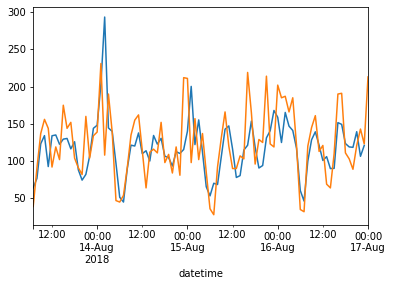

In [42]:
x_test_linear['2018-08-13':'2018-08-16']['predicted'].plot()
y_test[:90].plot()

##### Посмотрим поближе.

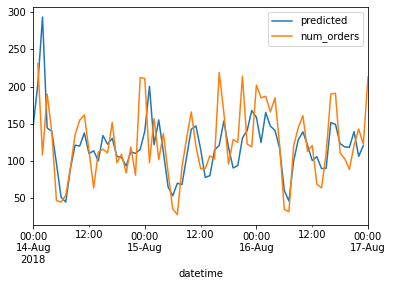

In [43]:
x_test_linear['2018-08-14':'2018-08-16']['predicted'].plot(legend=True)
y_test[18:90].plot(legend=True)

##### Видим, что регрессия плохо предсказывает пиковые вечерние нагрузки. У неё скорее равномерные предсказания без учёта внутридневной сезонности. Увеличение параметра lag улучшает предсказания модели Линейной регрессии и ухудшает предсказания LightGBM.

### Проверка LightGBM на тестовой выборке.

In [44]:
gbm = lgb.LGBMRegressor(num_leaves=31, max_depth=10, min_child_samples=10,random_state=12345, n_jobs=-1).fit(x_train, y_train)
answers_gbm = gbm.predict(x_test, num_iteration=gbm.best_iteration_)
print('RMSE LightGBM:', round(mean_squared_error(y_test, answers_gbm)**0.5,5))

RMSE LightGBM: 56.73583


### Результаты:
1. Были подготовлены данные для обучения и в них добавлены обучающие признаки.
2. Были обучены разные модели. Модели градиентного бустинга не дали никакого преимущества.
3. Более того, модели градиентного бустинга LightGBM, Catboost, XGBoost значительно уступили модели Линейной регрессии на тестовой выборке.
4. Лучший результат на тестовой выборке показала модель Линейная регрессия с RMSE - 46.36298
5. Вторая по результату на валидационной выборке модель LightGBM - RMSE 56.73583.